# UNIHIST: Fast Histogram and Weighted Random Sampling with Replacement for Data-Parallel Devices
We introduce the fast histogram computing algorithm for non-uniform bins, UNIHIST, that avoids bin-search and, instead, uses iterative method for bin indices refinement. Approximate bin indices are computed using parallel map operation, which makes the algorithm suitable for implementation for data-parallel devices. We demonstrate superior performance of the method using uniform and log-scale map functions, but the method is easily extensible to other maps. It is also extensible to multi-dimensional histogram computation. Finally, we demonstrate how the same technique can be applied for generalized discrete random number generation. Our implementation leverages oneAPI DPC++ compiler to run the code on both CPU and GPU devices. 

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

### Uniform Bins
Due to simplicity of determining of a bin index many research studies focus on uniform bins case:

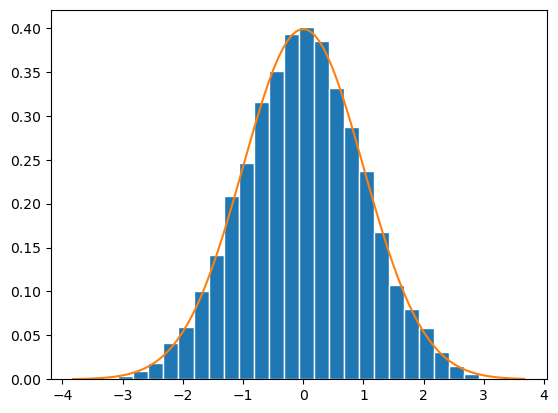

In [8]:
N = 10000
np.random.seed(7777777)
a = np.random.normal(0.0, 1.0, N)
counts, bins = np.histogram(a, bins=30, density=True)
bars = plt.hist(bins[:-1], bins, weights=counts, edgecolor='white')
x = np.linspace(bins[0], bins[-1], 100)
plt.plot(x, norm.pdf(x))
plt.savefig('images/uniform_bins.png', format='png', dpi=300)

### Non-Uniform Bins
Choosing non-uniform bins allows flexibility in smoothing or catching local peaks and distribution tails

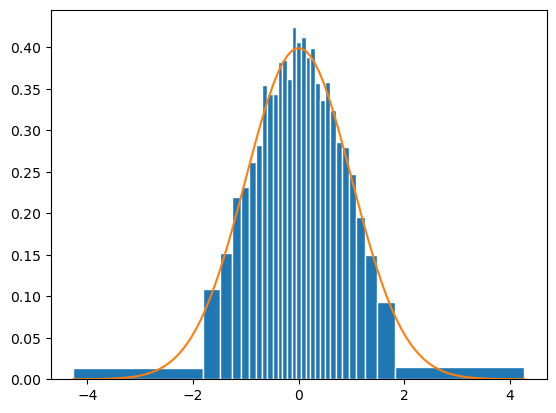

In [9]:
from scipy.stats import norm
p = np.linspace(0.00001, 0.99999, 30)
bins = norm.ppf(p)

x = np.linspace(bins[0], bins[-1], 100)

counts, bins = np.histogram(a, bins, density=True)
plt.hist(bins[:-1], bins, weights=counts, edgecolor='white')
plt.plot(x, norm.pdf(x))

plt.savefig('images/nonuniform_bins.png', format='png', dpi=300)

### Bin size selection based on *a priori* distribution
If the distribution is known in advance the bin sizes can be chosen in such a way that allow computing bin index using formula with complexity of computing $CDF(x)$

Generally with predictor-corrector approach, you do not need to know CDF accurately. This fact allows:
* Balance CDF approximation accuracy and speed
* Use density estimation methods on a subset of data for bin-size selection

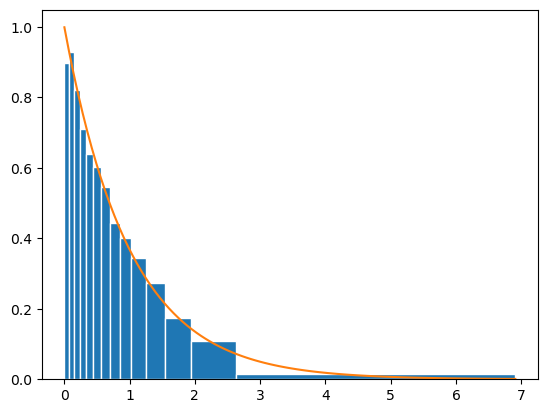

In [10]:
np.random.seed(777777777)
from scipy.stats import expon
a = np.random.exponential(1.0, N)
p = np.linspace(0.001, 0.999, 15)
bins = expon.ppf(p)

x = np.linspace(bins[0], bins[-1], 100)

counts, bins = np.histogram(a, bins, density=True)
plt.hist(bins[:-1], bins, weights=counts, edgecolor='white')
plt.plot(x, expon.pdf(x))

plt.savefig('images/exp_bins.png', format='png', dpi=300)

### Example of selection of bin-size for exponential distribution
Logarithmically chosen bins allow simple formula to compite bin index 

/tmp/ipykernel_10174/70500896.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


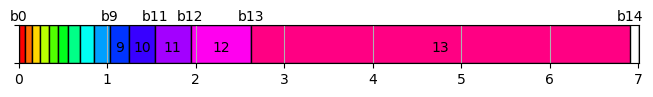

In [12]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(0.5)
ax.set_yticklabels([])
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.xlim(0, bins[-1]+0.1)
plt.ylim(0.0, 1.0)

def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(len(bins))

for i in range(len(bins)-1):
    ax.add_patch(Rectangle((bins[i], 0.0), bins[i+1]-bins[i], 1.0, facecolor=cmap(i), edgecolor='black'))
    if i > 10:
        ax.text(bins[i], 1.1, f'b{i}', ha='center')
ax.text(bins[0], 1.1, f'b{0}', ha='center')
ax.text(bins[9], 1.1, f'b{9}', ha='center')
ax.text(bins[14], 1.1, f'b{14}', ha='center')
ax.text(bins[9]+(bins[10]-bins[9])*0.5, 0.3, f'{9}', ha='center')
ax.text(bins[10]+(bins[11]-bins[10])*0.5, 0.3, f'{10}', ha='center')
ax.text(bins[11]+(bins[12]-bins[11])*0.5, 0.3, f'{11}', ha='center')
ax.text(bins[12]+(bins[13]-bins[12])*0.5, 0.3, f'{12}', ha='center')
ax.text(bins[13]+(bins[14]-bins[13])*0.5, 0.3, f'{13}', ha='center')
plt.savefig('images/log_bins.png', format='png', dpi=300, bbox_inches='tight')

### Uniform bins
Illustration of formula (1) in the paper

/tmp/ipykernel_10174/2623153321.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


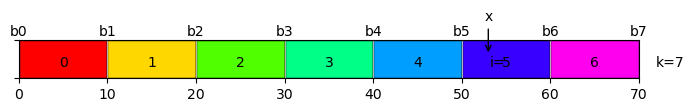

In [13]:
from math import floor

bins = np.asarray([0, 10, 20, 30, 40, 50, 60, 70])
n = bins.shape[0] - 1
u_step = (bins[n] - bins[0]) / n

from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(0.5)
ax.set_yticklabels([])
ax.xaxis.grid(True)
plt.xlim(bins[0], bins[-1])
plt.ylim(0.0, 1.0)

def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(len(bins))

for i in range(len(bins)-1):
    ax.add_patch(Rectangle((bins[i], 0.0), bins[i+1]-bins[i], 1.0, facecolor=cmap(i), edgecolor='black'))
    ax.text(i*u_step + u_step*0.5, 0.3, f'{i}', ha='center')
    ax.text(i*u_step, 1.1, f'b{i}', ha='center')
ax.text(n*u_step+3.5, 0.3, 'k=7', ha='center')
ax.text(n*u_step, 1.1, f'b{(len(bins)-1)}', ha='center')
plt.annotate(
'x', xy=(5*u_step + 0.3*u_step, 0.6),xytext=(5*u_step + 0.3*u_step, 1.5) ,
horizontalalignment="center",
arrowprops=dict(arrowstyle='->',lw=1)
)
ax.text(5*u_step + 0.3*u_step+1, 0.3, 'i=', ha='center')

plt.savefig('images/uniform_bins_map.png', format='png', dpi=300, bbox_inches='tight')

### Illustration of UNIHIST method
In this method we use the predictor-corrector approach to iteratively compute the accurate bin index. In contrast to a binary search, where predictor-corrector rule is always the middle bin, our predictor-corrector rule is more sofisticated and is based on the assumption that the bin widths do not have much variability.

In [14]:
from math import floor

bins = np.asarray([0, 21, 25, 28, 44, 47, 57, 70])
n = bins.shape[0] - 1
u_step = (bins[n] - bins[0]) / n

counts = np.zeros(n, dtype=int)
offsets = np.zeros(n, dtype=int)
k_prev = 0
for i in range(1, n):
    k = floor((bins[i] - bins[0]) / u_step)
    counts[k] += 1
    offsets[k_prev:k+1] = i-1
    k_prev = k+1
offsets[k_prev:] = n-1


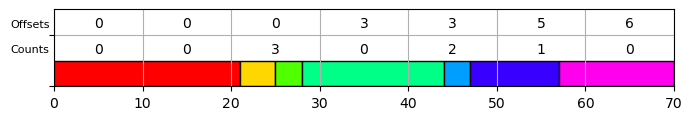

In [15]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(1.0)
ax.set_yticklabels([])
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.xlim(bins[0], bins[-1])
plt.ylim(0.0, 3.0)
plt.gcf().text(0.07, 0.45, 'Counts', fontsize=8)
plt.gcf().text(0.07, 0.7, 'Offsets', fontsize=8)

for i in range(len(bins)-1):
    ax.add_patch(Rectangle((bins[i], 0.0), bins[i+1]-bins[i], 1.0, facecolor=cmap(i), edgecolor='black'))
    ax.text(i*u_step + u_step*0.5, 1.3, f'{counts[i]}', ha='center')
    ax.text(i*u_step + u_step*0.5, 2.3, f'{offsets[i]}', ha='center')
    
plt.savefig('images/grid_step0.png', format='png', dpi=300, bbox_inches='tight')

In [16]:
ix = 2
offset = offsets[ix]
sub_n = counts[ix] + 1
sub_bins = np.zeros(sub_n + 1)
sub_bins[0] = ix * u_step + bins[0]
sub_bins[1:sub_n] = bins[offset+1:offset+sub_n]
sub_bins[-1] = (ix + 1) * u_step + bins[0]
print(sub_bins)

n = sub_bins.shape[0] - 1
u_step = (sub_bins[n] - sub_bins[0]) / n

counts = np.zeros(n, dtype=int)
offsets = np.zeros(n, dtype=int)
k_prev = 0
for i in range(1, n):
    k = floor((sub_bins[i] - sub_bins[0]) / u_step)
    counts[k] += 1
    offsets[k_prev:k+1] = i-1
    k_prev = k+1
offsets[k_prev:] = n-1


[20. 21. 25. 28. 30.]


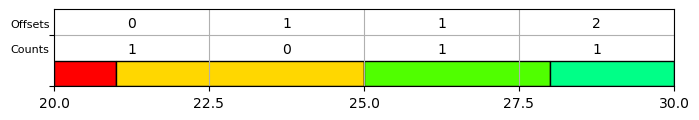

In [17]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(1)
ax.set_yticklabels([])
ticks = [i*u_step + sub_bins[0] for i in range(len(sub_bins))]
ax.set_xticks(ticks)
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.xlim(sub_bins[0], sub_bins[-1])
plt.ylim(0.0, 3.0)
plt.gcf().text(0.07, 0.45, 'Counts', fontsize=8)
plt.gcf().text(0.07, 0.7, 'Offsets', fontsize=8)

for i in range(len(sub_bins)-1):
    ax.add_patch(Rectangle((sub_bins[i], 0.0), sub_bins[i+1]-sub_bins[i], 1.0, facecolor=cmap(i), edgecolor='black'))
    ax.text(i*u_step + u_step*0.5 + sub_bins[0], 1.3, f'{counts[i]}', ha='center')
    ax.text(i*u_step + u_step*0.5 + sub_bins[0], 2.3, f'{offsets[i]}', ha='center')
    
plt.savefig('images/grid_step1.png', format='png', dpi=300, bbox_inches='tight')

In [20]:
np.random.seed(777777777)
hmin = 1
bins = np.array([0, hmin, hmin*2, hmin*3, hmin*4, hmin*5, hmin*6, 70])

n = bins.shape[0] - 1
u_step = (bins[n] - bins[0]) / n

print(bins)

[ 0  1  2  3  4  5  6 70]


### Worst case: all small bins but one are concentrated either on the left side or on the right side
Method convergence is determined by $\log(h/h_{min}) / \log(k)$, where $h$ is the total width of all bins, $h_{min}$ is the smallest bin width, and $k$ is the total number of bins

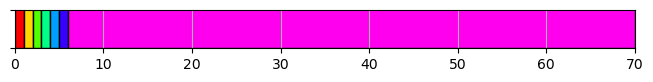

In [19]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(0.5)
ax.set_yticklabels([])
ax.xaxis.grid(True)
ax.yaxis.grid(True)

plt.xlim(bins[0], bins[-1])
plt.ylim(0.0, 0.5)

for i in range(len(bins)-1):
    ax.add_patch(Rectangle((bins[i], 0.0), bins[i+1]-bins[i], 1.0, facecolor=cmap(i), edgecolor='black'))
    
plt.savefig('images/worst_case.png', format='png', dpi=300, bbox_inches='tight')

### Multidimensional case

In [21]:
from math import floor

x_bins = np.asarray([0, 21, 25, 28, 50])
y_bins = np.asarray([0, 6, 30])

x_n = x_bins.shape[0] - 1
x_u_step = (x_bins[x_n] - x_bins[0]) / x_n

y_n = y_bins.shape[0] - 1
y_u_step = (y_bins[y_n] - y_bins[0]) / y_n

x_counts = np.zeros(x_n, dtype=int)
x_offsets = np.zeros(x_n, dtype=int)
k_prev = 0
for i in range(1, x_n):
    k = floor((x_bins[i] - x_bins[0]) / x_u_step)
    x_counts[k] += 1
    x_offsets[k_prev:k+1] = i-1
    k_prev = k+1
x_offsets[k_prev:] = x_n-1

y_counts = np.zeros(y_n+1, dtype=int)
y_offsets = np.zeros(y_n+1, dtype=int)
k_prev = 0
for i in range(1, y_n):
    k = floor((y_bins[i] - y_bins[0]) / y_u_step)
    y_counts[k] += 1
    y_offsets[k_prev:k+1] = i-1
    k_prev = k+1
y_offsets[k_prev:] = y_n-1

/tmp/ipykernel_10174/1796290176.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


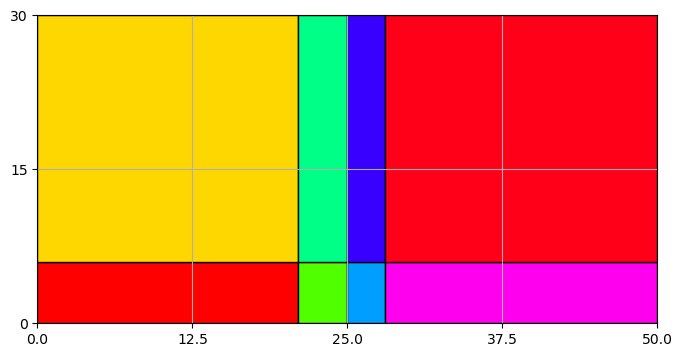

In [22]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(4)
ax.set_xticks([i*(x_bins[x_n]-x_bins[0])/x_n for i in range(len(x_bins))])
ax.set_yticks([i*(y_bins[y_n]-y_bins[0])/y_n for i in range(len(y_bins))])
ax.xaxis.grid(True)
ax.yaxis.grid(True)

def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(x_n*y_n, name='hsv')

plt.xlim(x_bins[0], x_bins[-1])
plt.ylim(y_bins[0], y_bins[-1])

ci = 0
for i in range(x_n):
    for j in range(y_n):  
        ax.add_patch(Rectangle((x_bins[i], y_bins[j]), x_bins[i+1]-x_bins[i], y_bins[j+1]-y_bins[j], facecolor=cmap(ci), edgecolor='black'))
        ci += 1
    
plt.savefig('images/2d.png', format='png', dpi=300, bbox_inches='tight')